In [1]:
import pandas as pd
import numpy as np
import sys
import math
import seaborn as sns
from matplotlib import pyplot as plt
import umap.umap_ as umap
import scipy.stats as stats
from tribus import run_tribus, heatmap_for_median_expression, umap_vis, z_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

In [12]:
# if save session
import dill
dill.dump_session('stellar_notebook_env.db')

In [2]:
# restore session
import dill
dill.load_session('stellar_notebook_env.db')

## Marker quality check

In [19]:
# read input files
sample_data = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
sample_data = sample_data.drop(["...1", "x","y","tissue","cell_type_A","donor","unique_region","cell_type_upperlevel"], axis=1)

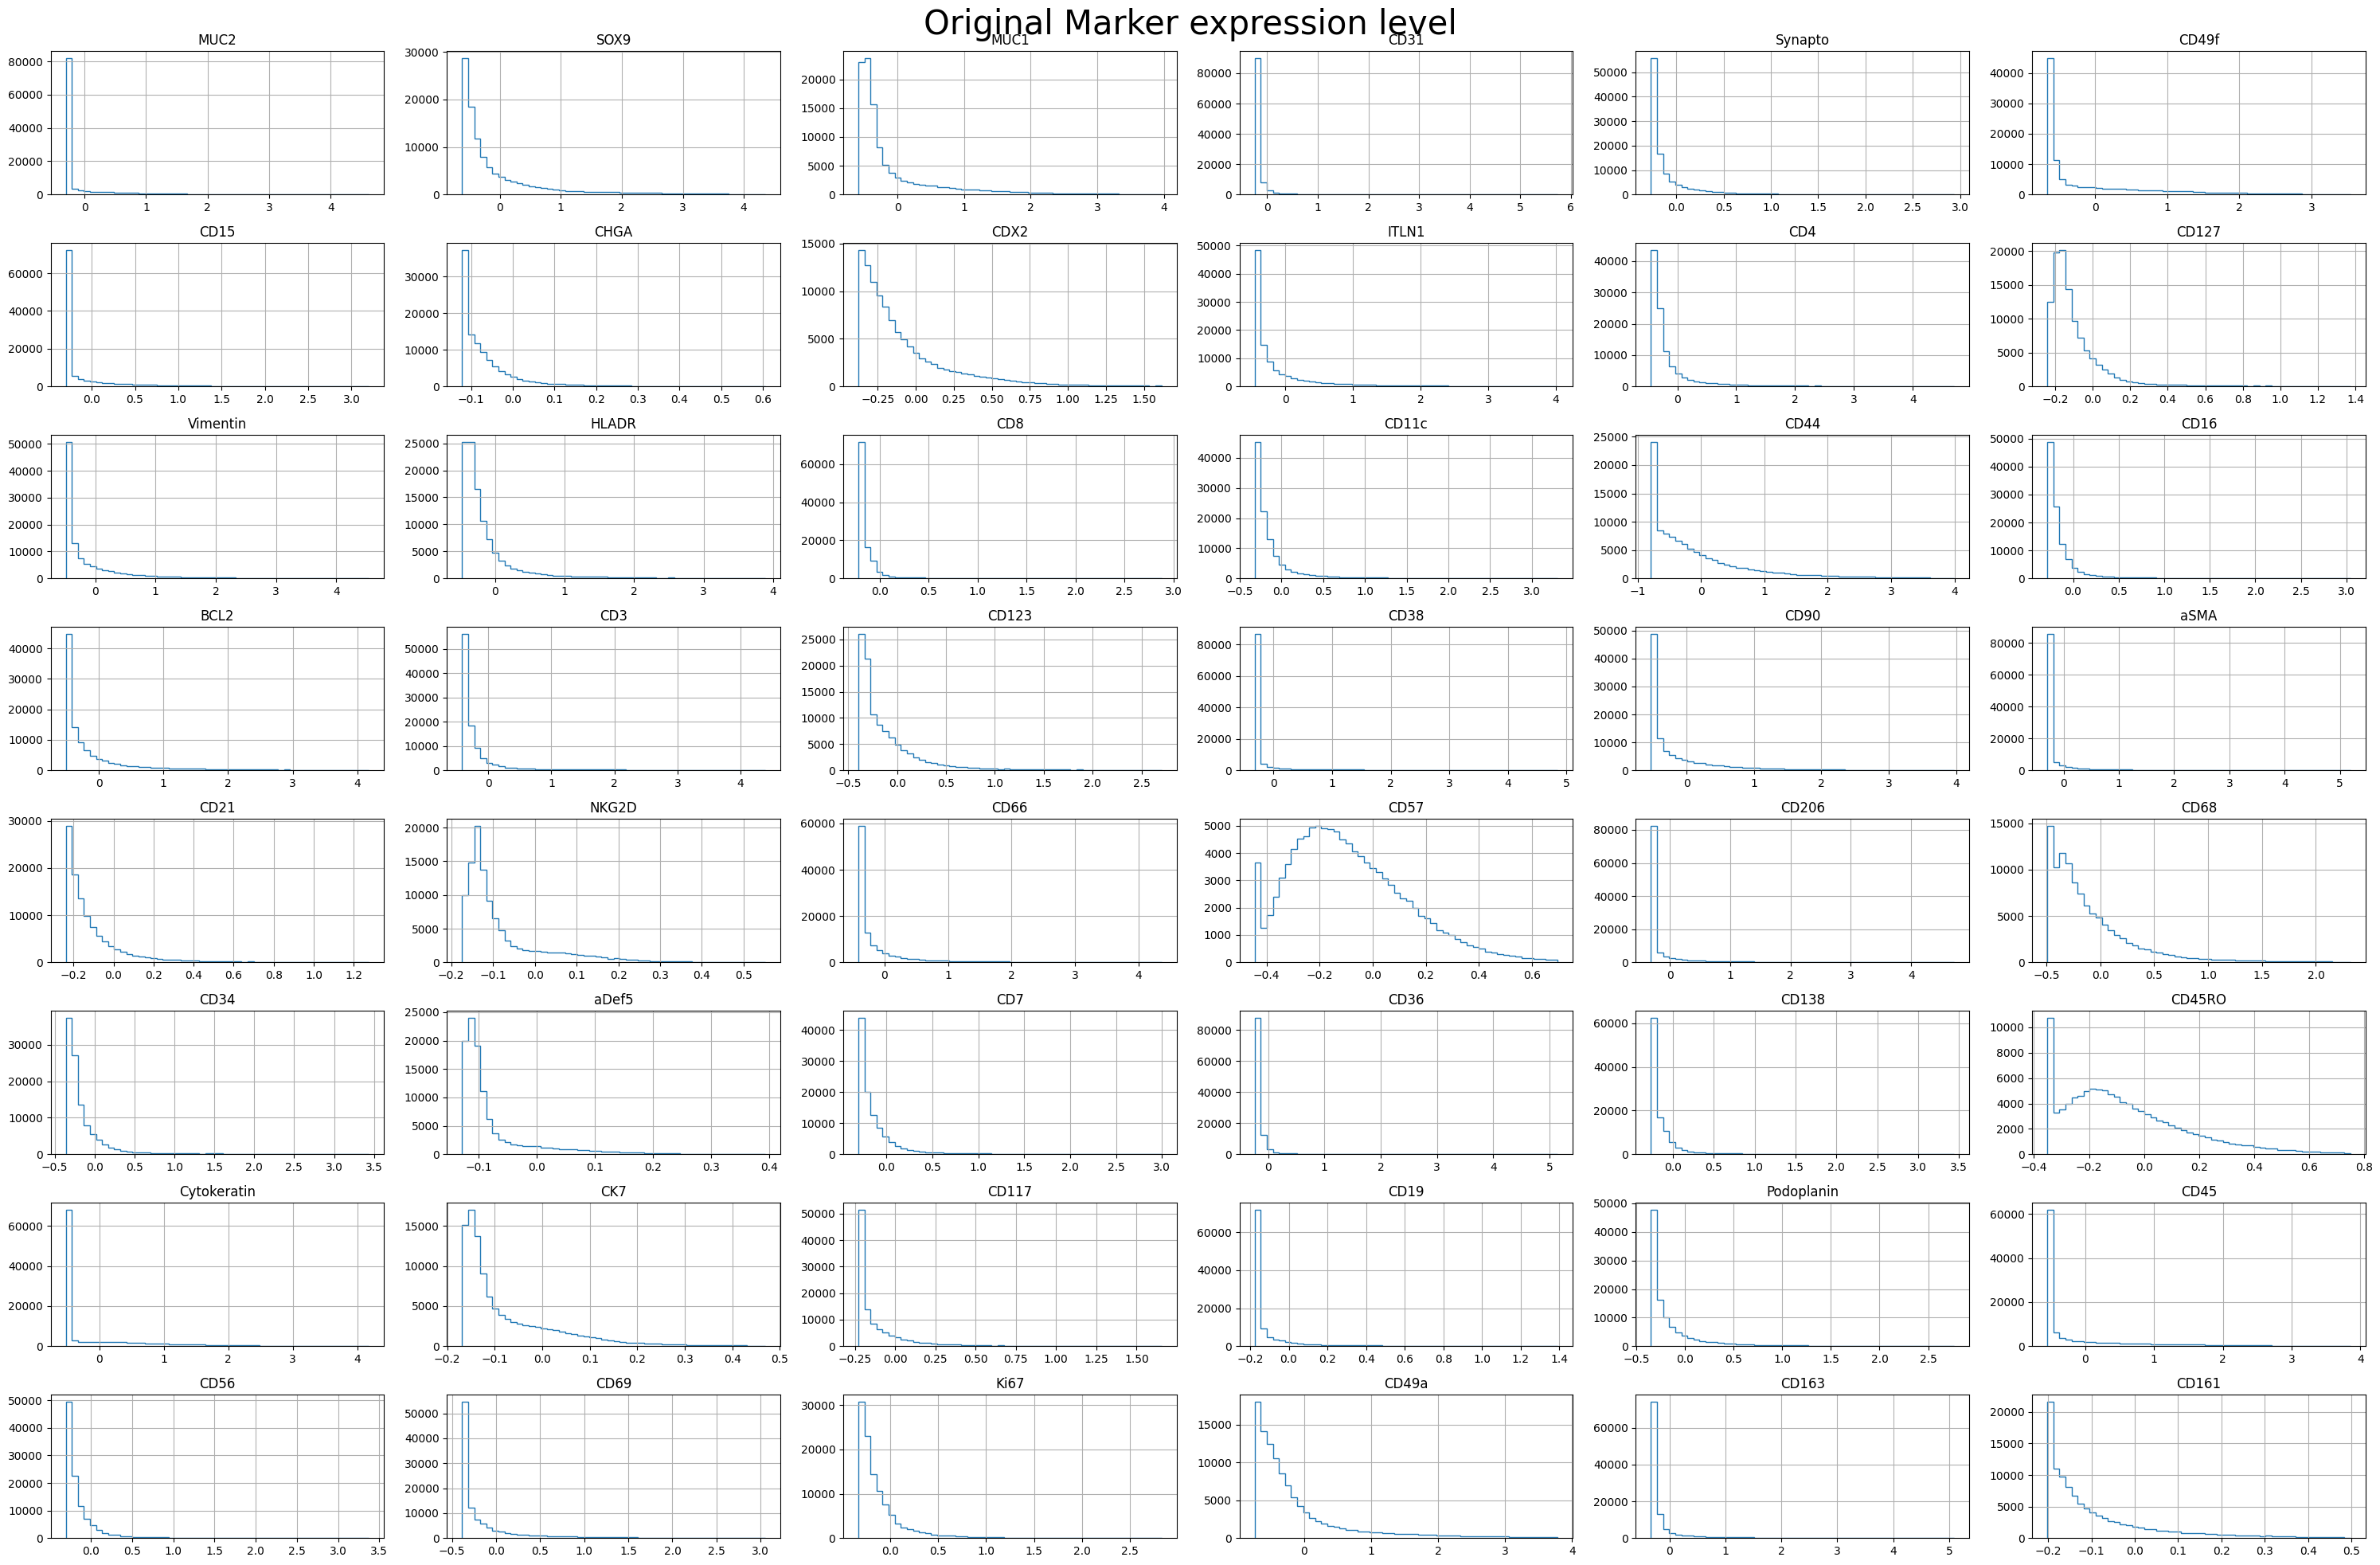

In [20]:
# Plot marker histograms after filter with 99% percentiles
markers = sample_data.columns.values

fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 20))
fig.suptitle("Original Marker expression level", fontsize=30)
for i in range(len(markers)): 
    ax = axs[i//6, i%6]
    plt.sca(ax)
    hist, edges = np.histogram(sample_data[markers[i]][sample_data[markers[i]] < np.percentile(sample_data[markers[i]],99)], bins=50)
    plt.stairs(hist, edges, label="{}".format(markers[i]))
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()

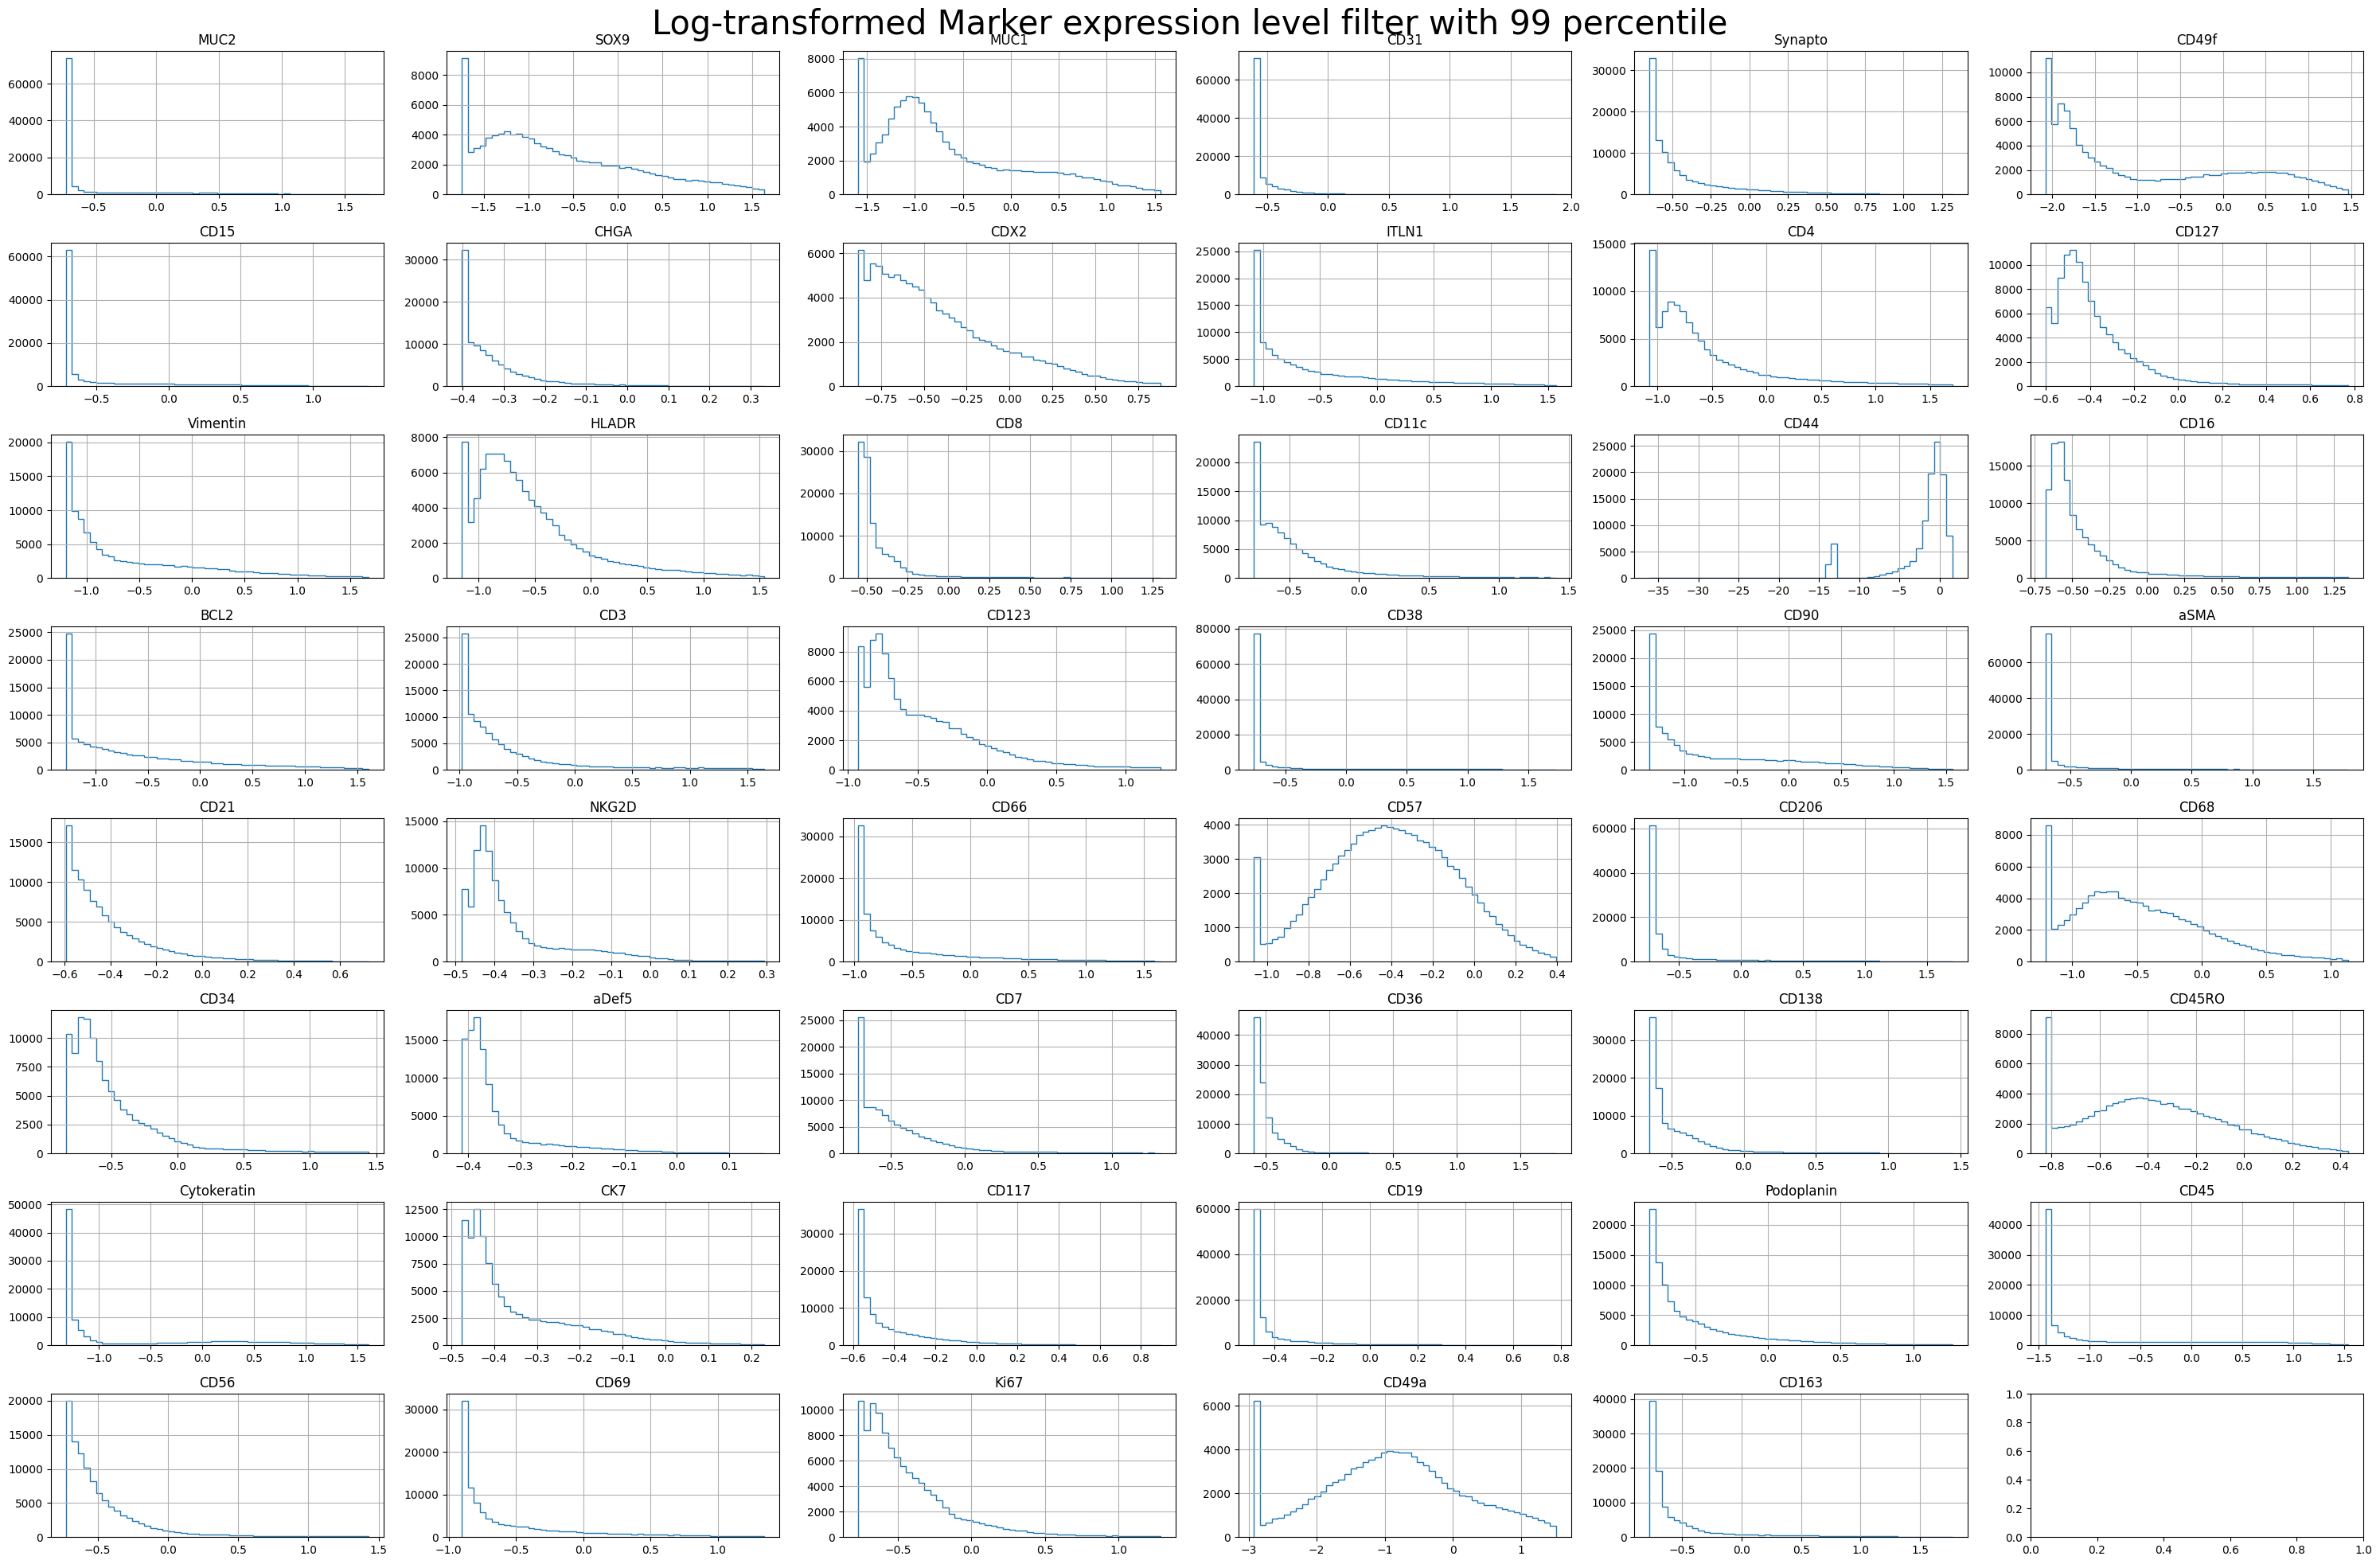

In [21]:
# Plot log transformed marker histograms after filter with 99% percentiles
sample_data_log = np.log(sample_data + abs(np.min(sample_data)) + sys.float_info.epsilon)
# sample_data_scaled = (sample_data_log - np.mean(sample_data_log)) / (np.std(sample_data_log))
# sample_data_norm = (sample_data_log - np.min(sample_data_log))/(np.max(sample_data_log) - np.min(sample_data_log))

fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 20))
fig.suptitle("Log-transformed Marker expression level filter with 99 percentile", fontsize=30)
for i in range(len(markers)-1): 
    ax = axs[i//6, i%6]
    plt.sca(ax)
    hist, edges = np.histogram(sample_data_log[markers[i]][sample_data_log[markers[i]] < np.percentile(sample_data_log[markers[i]],99)], 
                               bins=50)
    plt.stairs(hist, edges, label="{}".format(markers[i]))
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()

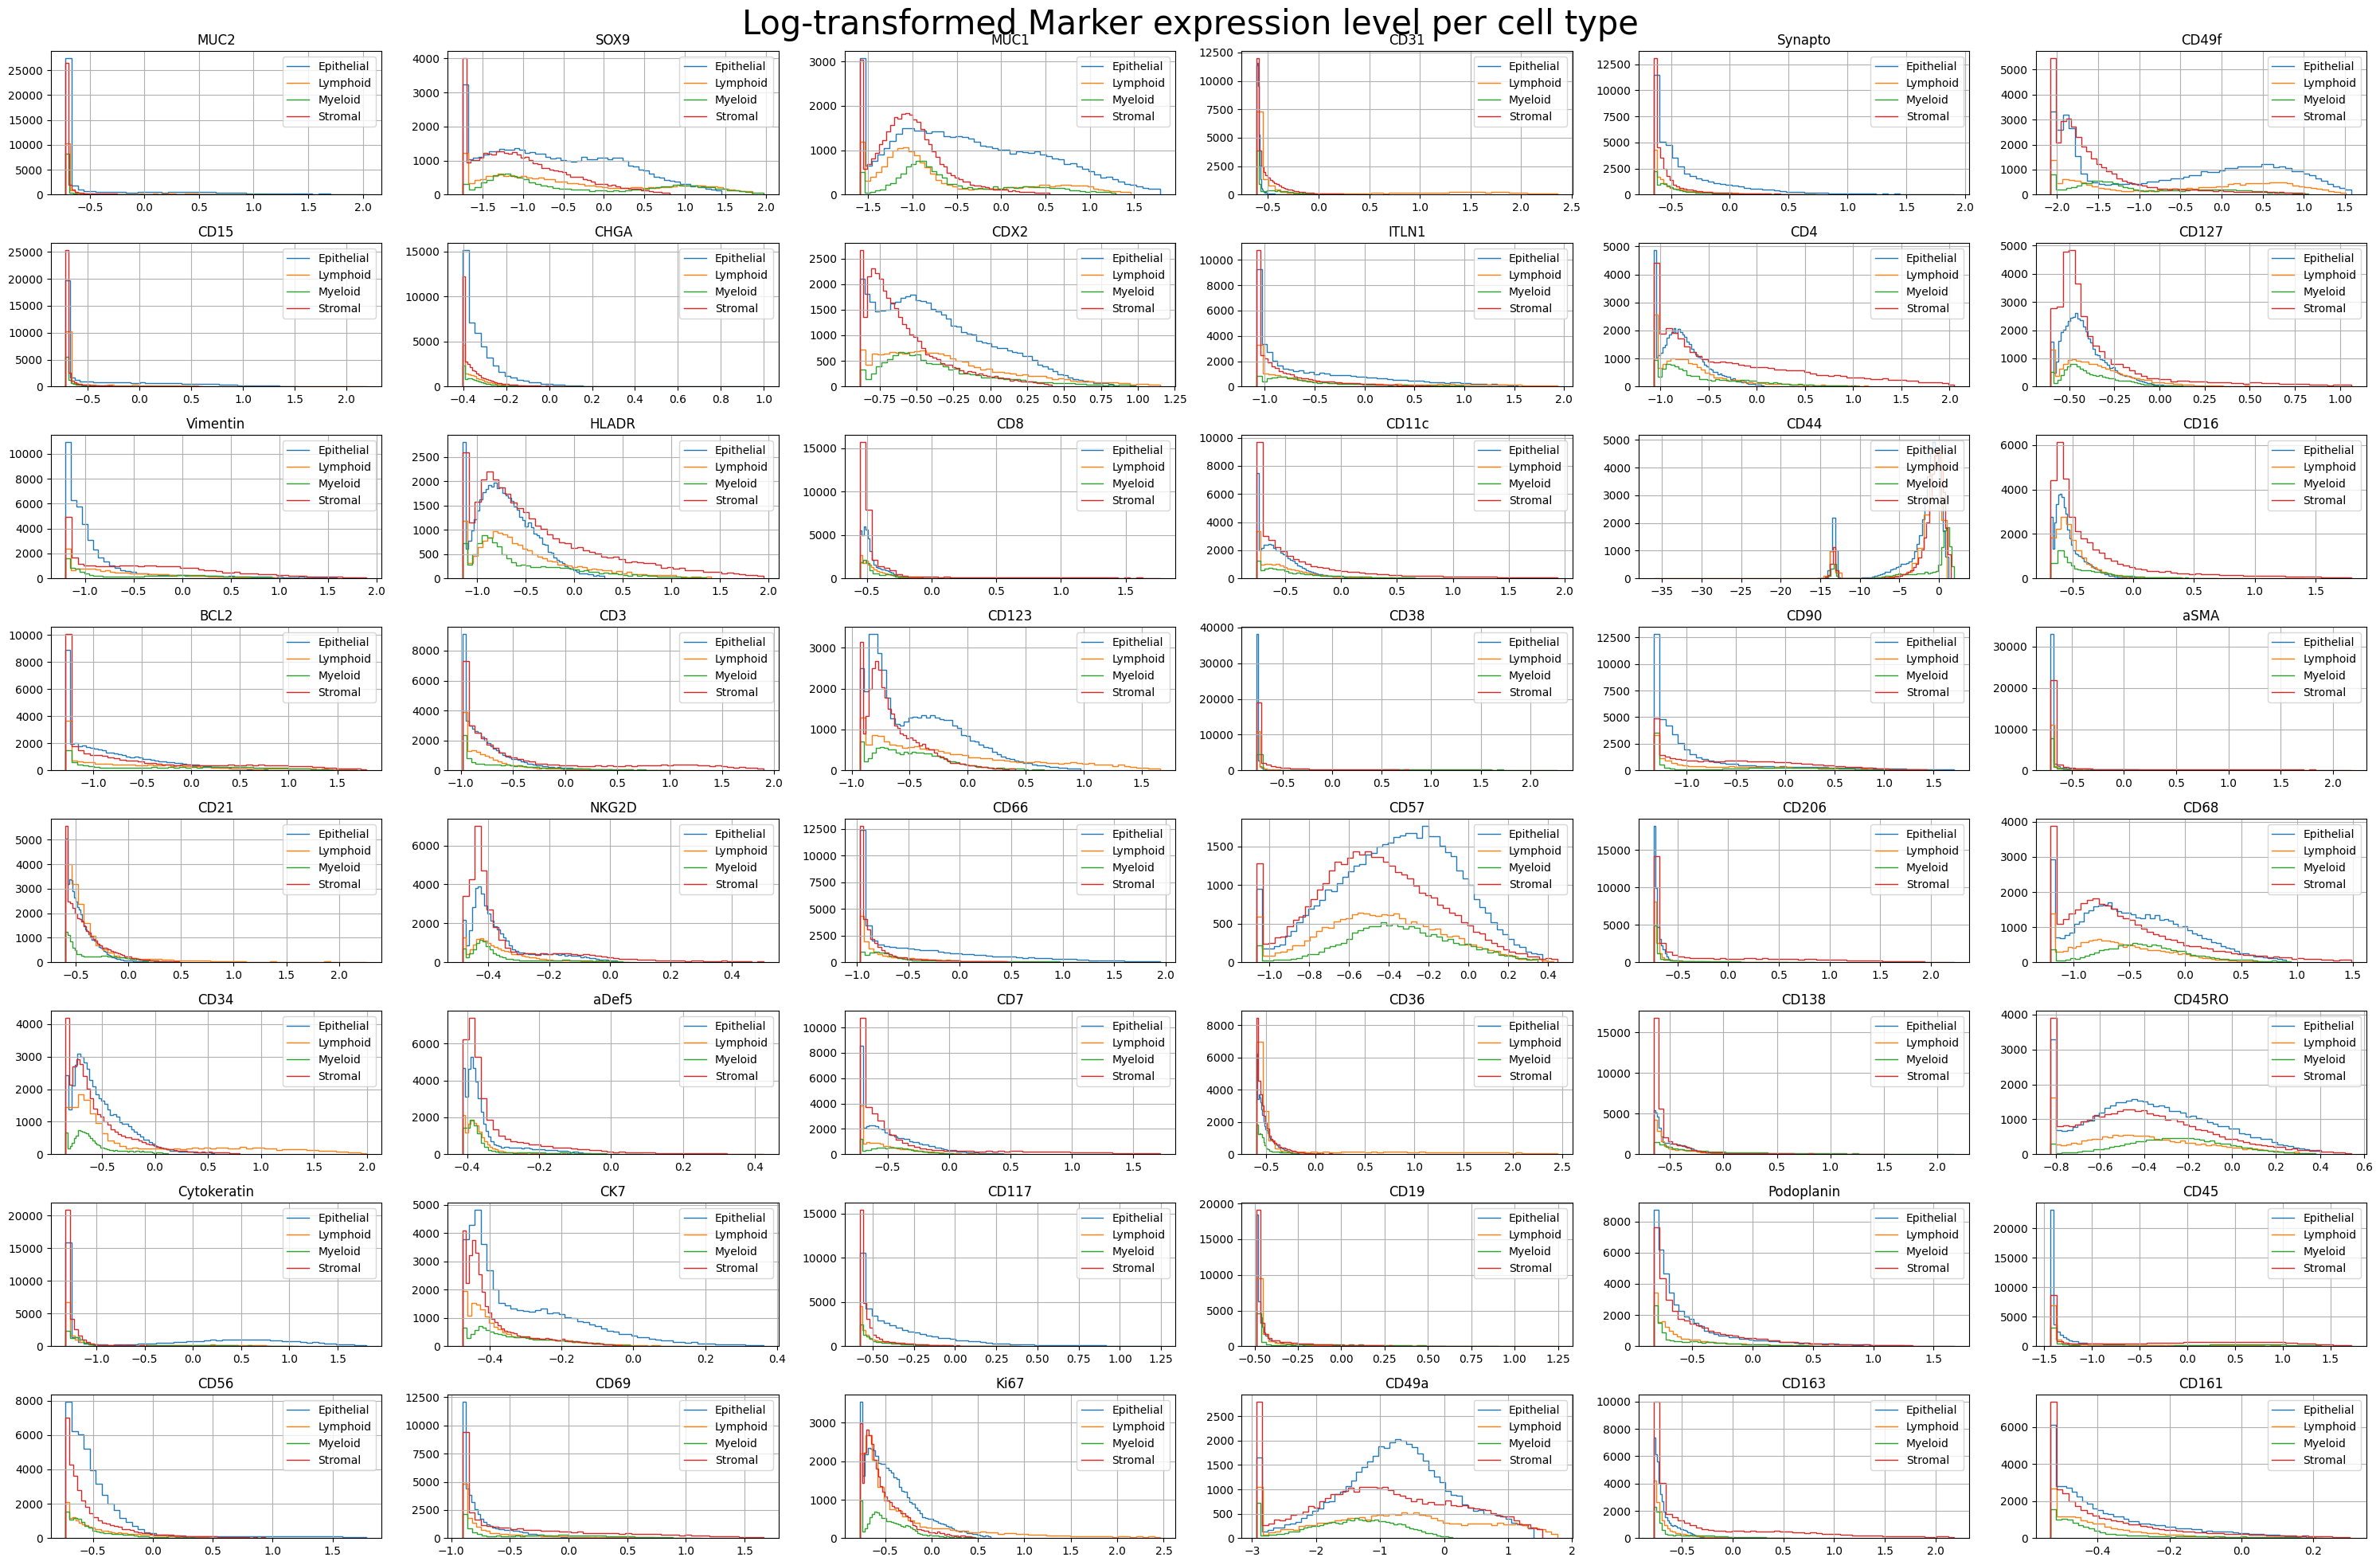

In [22]:
# Plot marker expression histogram for each level 1 cell types
markers = sample_data.columns.values
sample_data_labeled = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel.csv',low_memory=False)
upper_celltype = np.unique(sample_data_labeled["cell_type_upperlevel"])
sample_data_log = np.log(sample_data + abs(np.min(sample_data)) + sys.float_info.epsilon)
sample_data_labeled_plot = sample_data_log.assign(cell_type_upperlevel=sample_data_labeled["cell_type_upperlevel"])

fig, axs = plt.subplots(math.ceil(len(markers) / 6), 6, figsize=(30, 20))
fig.suptitle("Log-transformed Marker expression level per cell type", fontsize=30)

for i in range(len(markers)): 
    ax = axs[i//6, i%6]
    plt.sca(ax)
    for uc in upper_celltype: 
        subset = sample_data_labeled_plot.loc[sample_data_labeled_plot["cell_type_upperlevel"]==uc]
        hist, edges = np.histogram(subset[markers[i]][subset[markers[i]] < np.percentile(subset[markers[i]],99)], bins=50)
        plt.stairs(hist, edges, label="{}".format(uc))
        plt.legend(loc='upper right')
    plt.title(f"{markers[i]}")
    plt.grid()
    plt.tight_layout()
plt.show()


## Analysis STELLAR dataset donor_004

In [2]:
# read input files
sample_data = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
df = pd.ExcelFile(r"C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\\STELLAR\\stellar_logic_gate_cl.xlsx")
logic = pd.read_excel(df, df.sheet_names, index_col=0)
sample_data = sample_data.drop(["...1"], axis=1)
sample_data

MUC2      SOX9      MUC1      CD31   Synapto     CD49f      CD15   
0      -0.304218 -0.608013  0.167281 -0.245856 -0.132849 -0.285908 -0.200287  \
1      -0.304202 -0.610319 -0.011023 -0.241806  0.057781 -0.531741 -0.051784   
2      -0.304218 -0.615591 -0.587610 -0.247548 -0.266694  0.649361 -0.299029   
3      -0.304219 -0.615593 -0.446454 -0.246986 -0.258241  0.204627 -0.293732   
4      -0.303740 -0.606901 -0.256430 -0.243195 -0.100834  0.193785 -0.168101   
...          ...       ...       ...       ...       ...       ...       ...   
110628 -0.301417 -0.480617 -0.485732 -0.247548 -0.075596 -0.601329 -0.296372   
110629 -0.302128 -0.469591 -0.486481 -0.201661 -0.252108 -0.632735 -0.291958   
110630 -0.300624 -0.505039 -0.481408 -0.206155 -0.257355 -0.611439 -0.297305   
110631 -0.241006 -0.217832 -0.350860 -0.235930  0.407688 -0.585294 -0.297135   
110632 -0.304218 -0.570549 -0.477373 -0.247548 -0.256739 -0.609668 -0.284186   

            CHGA      CDX2     ITLN1  ...     CD49a     CD163     CD161     x   
0      -0.026299 -0.100164 -0.277870  ... -0.542636 -0.201896 -0.173699  1049  \
1       0.090001 -0.250907 -0.015182  ... -0.584995 -0.232360 -0.135534  1077   
2      -0.121452  0.052088 -0.450795  ... -0.586992 -0.239718 -0.201726  1093   
3      -0.121439 -0.114584 -0.438170  ... -0.579588 -0.274527 -0.200725  1114   
4       0.006306 -0.003393 -0.229224  ... -0.368494 -0.175319 -0.163558  1127   
...          ...       ...       ...  ...       ...       ...       ...   ...   
110628 -0.121456 -0.298825 -0.407754  ... -0.448915 -0.329448 -0.110390  8672   
110629 -0.089449 -0.345515 -0.399732  ... -0.648830 -0.263899 -0.104248  8727   
110630 -0.096474 -0.338581 -0.430508  ... -0.616562 -0.280333 -0.082285  9031   
110631 -0.069509 -0.099756 -0.256268  ... -0.387270 -0.120730 -0.058423  8335   
110632  0.213849 -0.260464 -0.427174  ... -0.460000 -0.309882  0.251603  3156   

           y  tissue  cell_type_A  donor   unique_region  cell_type_upperlevel  
0        708      CL   Enterocyte   B004  reg001_CL_B004            Epithelial  
1        917      CL   Enterocyte   B004  reg001_CL_B004            Epithelial  
2        926      CL   Enterocyte   B004  reg001_CL_B004            Epithelial  
3        809      CL   Enterocyte   B004  reg001_CL_B004            Epithelial  
4        792      CL   Enterocyte   B004  reg001_CL_B004            Epithelial  
...      ...     ...          ...    ...             ...                   ...  
110628  7054      CL       Plasma   B004  reg004_CL_B004              Lymphoid  
110629  6182      CL       Plasma   B004  reg004_CL_B004              Lymphoid  
110630  6452      CL       Plasma   B004  reg004_CL_B004              Lymphoid  
110631  7248      CL       Plasma   B004  reg004_CL_B004              Lymphoid  
110632  1849      CL   Enterocyte   B004  reg001_CL_B004            Epithelial  

[110633 rows x 55 columns]

<Axes: >

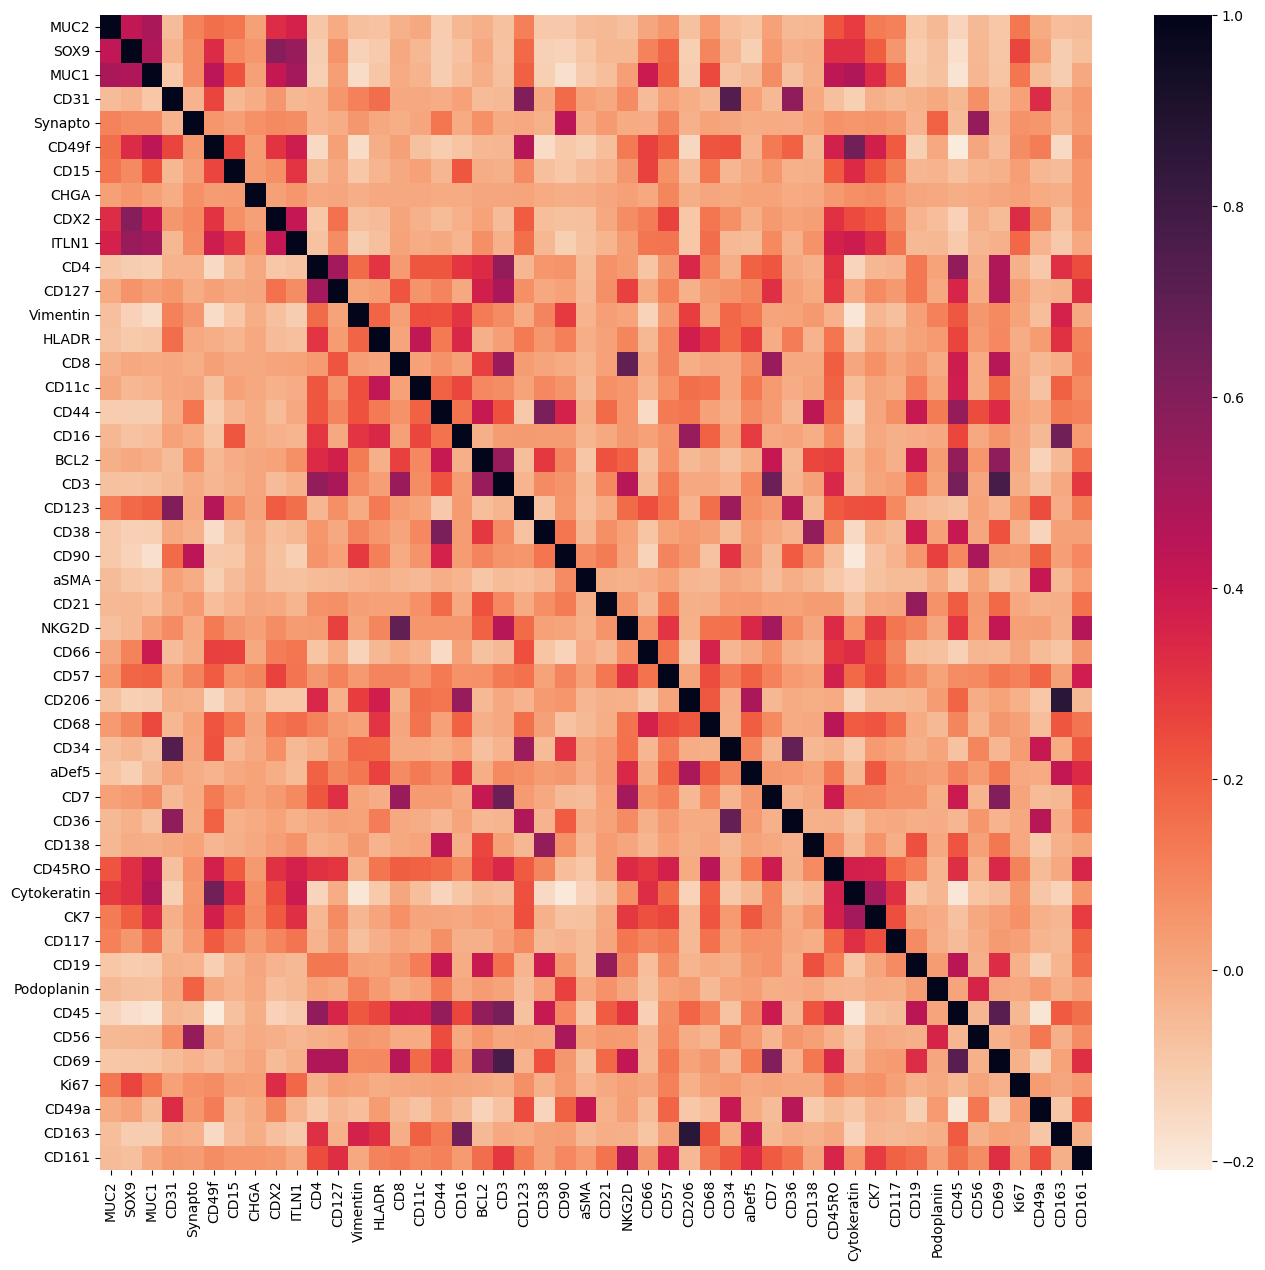

In [3]:
marker_df = sample_data.drop(["x","y","tissue","cell_type_A","donor","unique_region","cell_type_upperlevel"], axis=1)
plt.figure(figsize=(16, 15))
sns.heatmap(marker_df.corr(),cmap=sns.cm.rocket_r)

In [23]:
# Run Tribus on z-scored dataset
labels, scores = run_tribus(sample_data, logic, depth=1, normalization=z_score) # modify depth

Global, subsetting done
Global
Global, clustering done


In [24]:
labels.head(10)

Global final_label
0  Epithelial  Epithelial
1     Myeloid     Myeloid
2  Epithelial  Epithelial
3  Epithelial  Epithelial
4  Epithelial  Epithelial
5  Epithelial  Epithelial
6  Epithelial  Epithelial
7  Epithelial  Epithelial
8     Myeloid     Myeloid
9  Epithelial  Epithelial

## Visualize the result and check the quality

<BarContainer object of 5 artists>

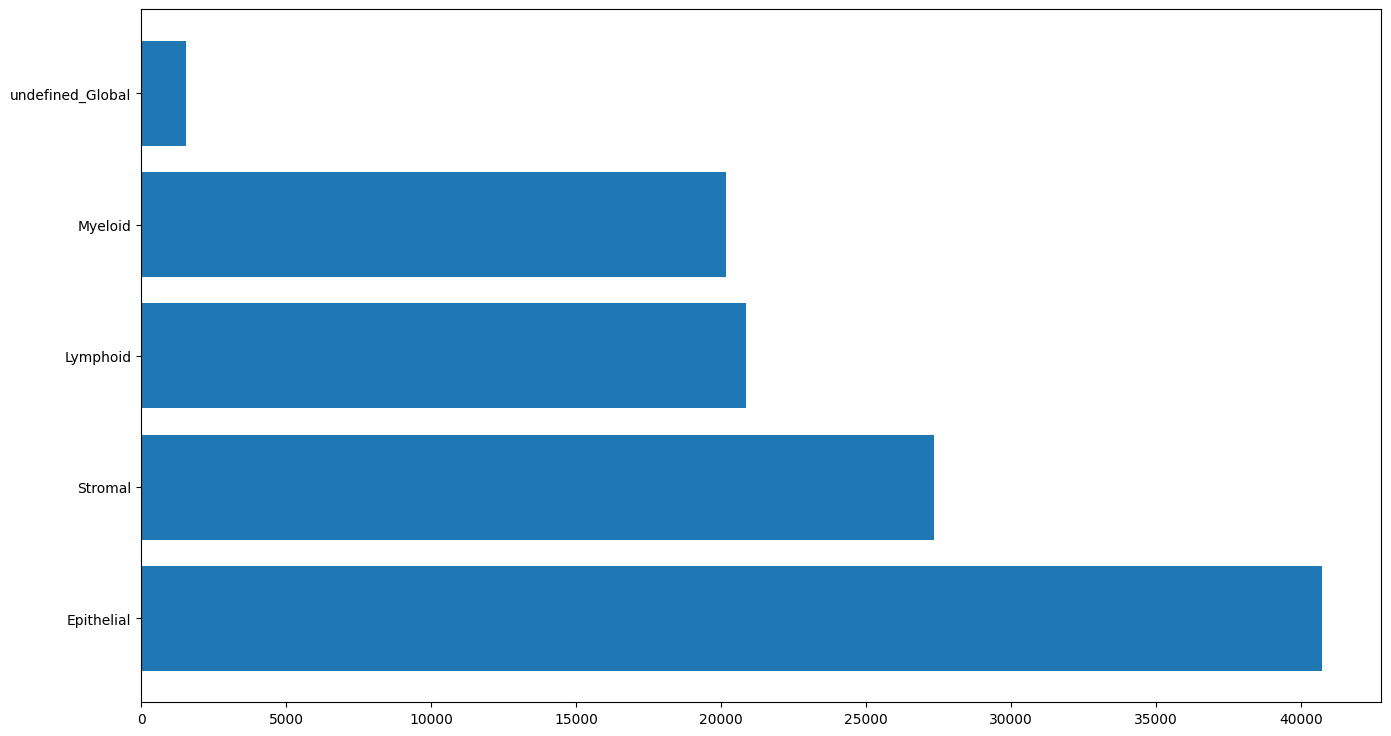

In [25]:
# Barplot, show the number of cells in each type
label_stat = labels["final_label"].value_counts().rename_axis('final_label').reset_index(name='count')
name = label_stat['final_label']
num = label_stat['count']
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(name, num)

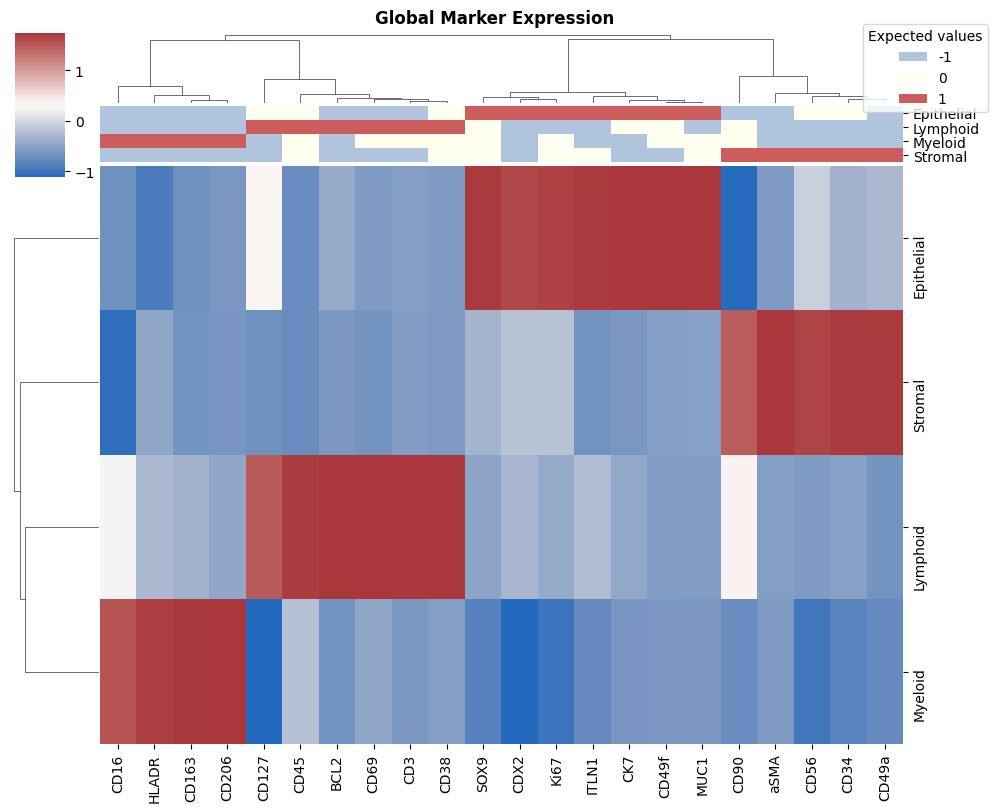

' heatmap_for_median_expression(sample_data, labels, logic, level="Myeloid", save=False, fname=None,\n                                  dpi=\'figure\', transform=stats.zscore, title="Myeloid Marker Expression",\n                                  c_palette=sns.color_palette([\'lightsteelblue\', \'ivory\', \'indianred\'], 3),\n                                  cmap_=\'vlag\', dendrogram_ratio_=0.1)\n\nheatmap_for_median_expression(sample_data, labels, logic, level="Lymphoid", save=False, fname=None,\n                                  dpi=\'figure\', transform=stats.zscore, title="Lymphoid Marker Expression",\n                                  c_palette=sns.color_palette([\'lightsteelblue\', \'ivory\', \'indianred\'], 3),\n                                  cmap_=\'vlag\', dendrogram_ratio_=0.1)\n\nheatmap_for_median_expression(sample_data, labels, logic, level="Stromal", save=False, fname=None,\n                                  dpi=\'figure\', transform=stats.zscore, title="Stromal Marke

In [26]:
# Marker Expression heatmap (use median value)

heatmap_for_median_expression(sample_data, labels, logic, level="Global", save=False, fname=None,
                                  dpi='figure', transform=z_score, title="Global Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

""" heatmap_for_median_expression(sample_data, labels, logic, level="Myeloid", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Myeloid Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

heatmap_for_median_expression(sample_data, labels, logic, level="Lymphoid", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Lymphoid Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1)

heatmap_for_median_expression(sample_data, labels, logic, level="Stromal", save=False, fname=None,
                                  dpi='figure', transform=stats.zscore, title="Stromal Marker Expression",
                                  c_palette=sns.color_palette(['lightsteelblue', 'ivory', 'indianred'], 3),
                                  cmap_='vlag', dendrogram_ratio_=0.1) """

C:\Users\Localadmin_kangzigi\AppData\Local\Temp\ipykernel_13620\3639515616.py:19: RuntimeWarning: invalid value encountered in true_divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Text(33.081597222222214, 0.5, 'True')

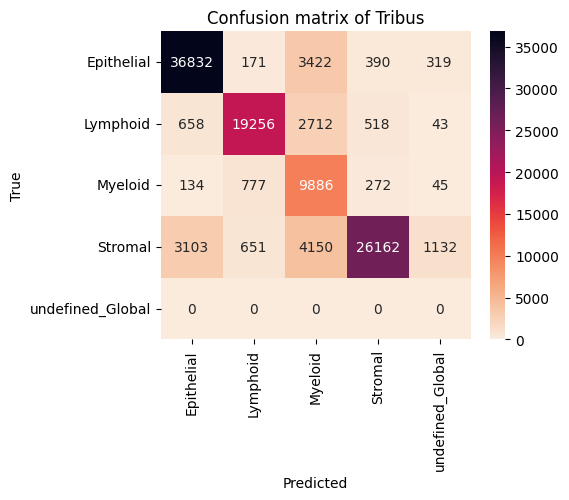

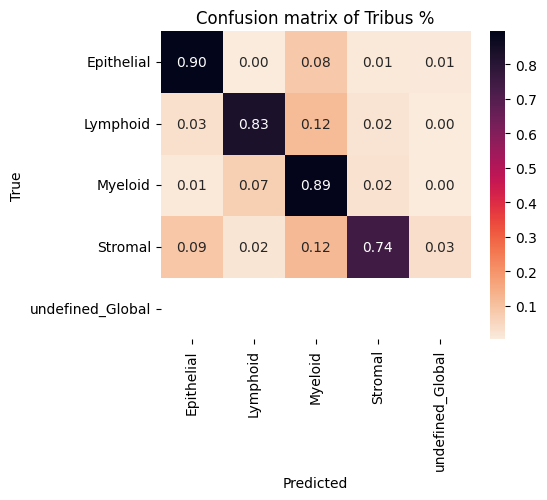

In [27]:
# confusion matrix
donor_004_upperlevel = pd.read_csv(r'C:\\Users\\Public\\Farkkila_lab_datasets\\Tribus\\Test_case_data\STELLAR\\input_data\\STELLAR_data_donor_004_upperlevel_CL.csv',low_memory=False)
celltype_true = np.array(donor_004_upperlevel["cell_type_upperlevel"]).tolist()
celltype_pred = np.array(labels["final_label"]).tolist()
cm_labels = np.unique(labels["final_label"])
cm = confusion_matrix(celltype_true, 
                      celltype_pred, 
                      labels = cm_labels)
                                                       
df_cm = pd.DataFrame(cm, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (5,4))
sns.heatmap(df_cm, fmt='g', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus')
plt.xlabel('Predicted')
plt.ylabel('True')


cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cmn = pd.DataFrame(cmn, index = cm_labels,
                  columns = cm_labels)
plt.figure(figsize = (5,4))
sns.heatmap(df_cmn, fmt='.2f', annot=True, cmap=sns.cm.rocket_r)
plt.title('Confusion matrix of Tribus %')
plt.xlabel('Predicted')
plt.ylabel('True')

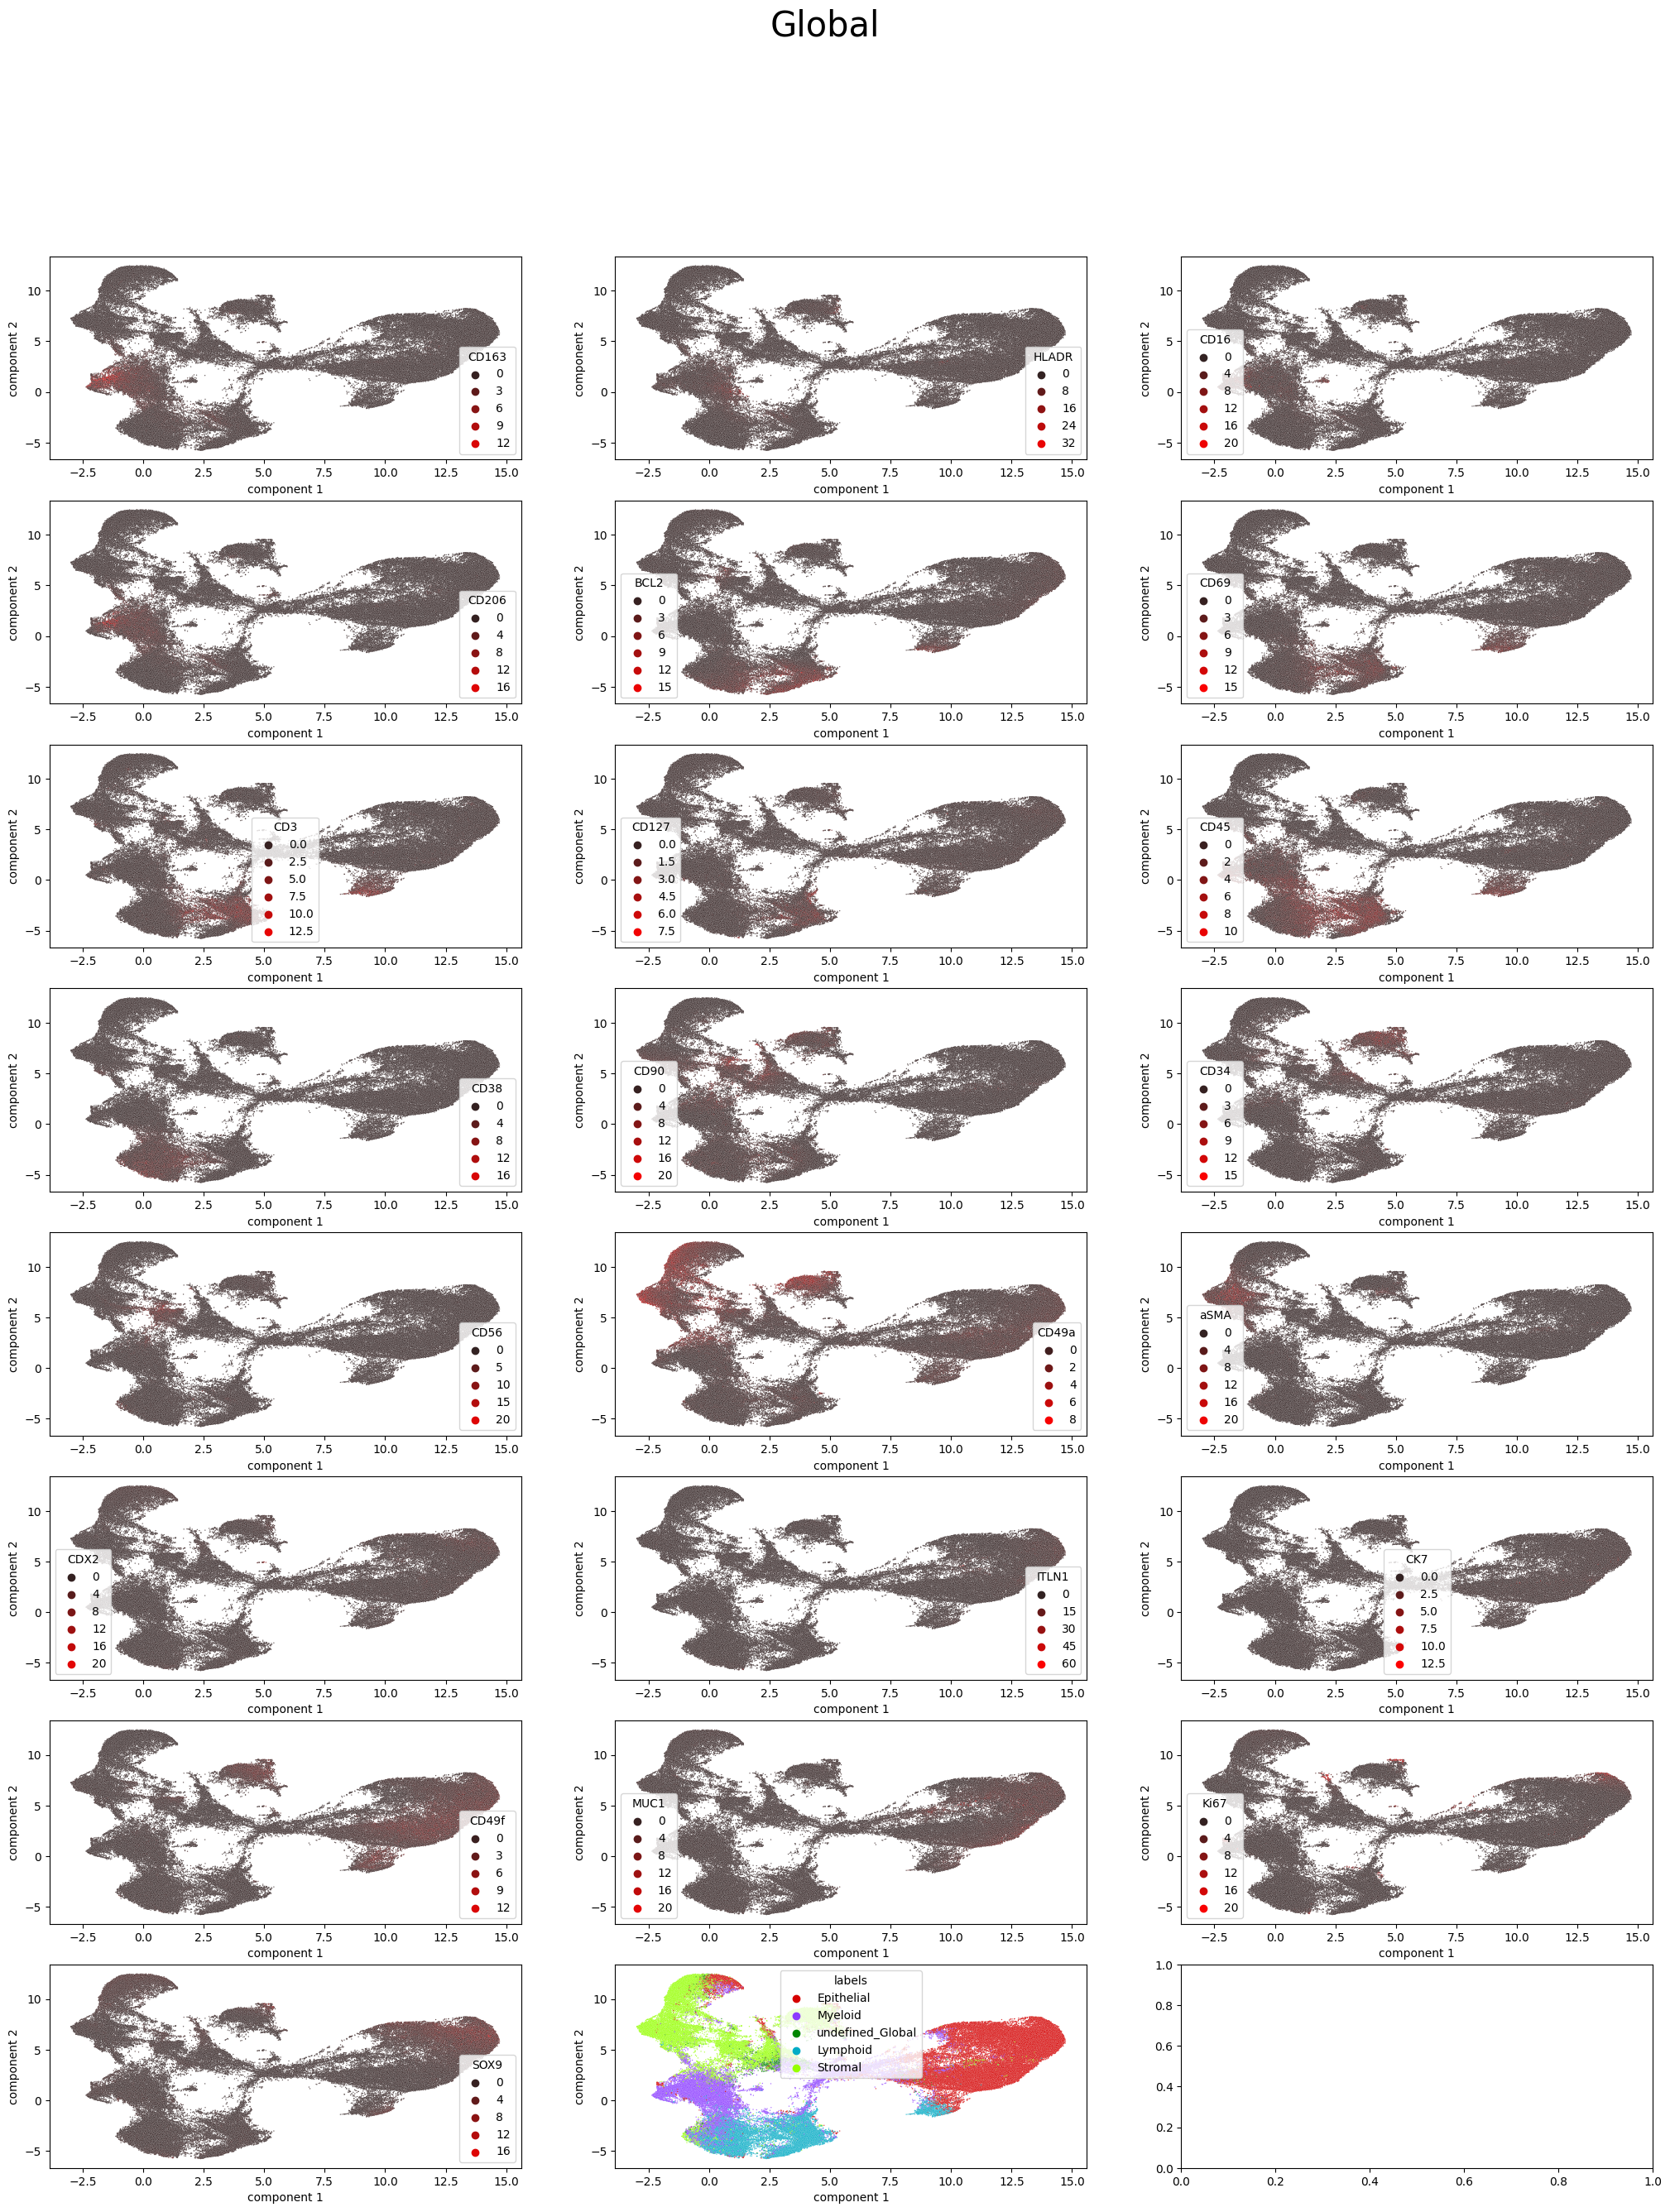

In [28]:
# scale the dataset into (0,1) before UMAP
#scaler = MinMaxScaler() 
#arr_scaled = scaler.fit_transform(sample_data)
#sample_data_scaled = pd.DataFrame(arr_scaled, columns=sample_data.columns,index=sample_data.index)

umap_vis(sample_data, labels, markers=logic["Global"].index.values.tolist(), save=False, fname=None,  level="Global", title=None, init='spectral',
             random_state=0, n_neighbors=10, min_dist=0.1, metric='correlation', palette_markers='mycolormap',
             palette_cell='tab10', dpi='figure')

## Save the cell typing result if satisfied

In [16]:
labels.to_csv(r"C:\Users\Public\Farkkila_lab_datasets\Tribus\Test_case_data\STELLAR\output_data\STELLAR_celltyping_v3.csv")